# Test the endpoint

In [31]:
import json, os, sys, re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

In [46]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.huggingface.model import HuggingFaceModel
from sagemaker.workflow.model_step import ModelStep
from sagemaker.workflow.pipeline_context import PipelineSession
from io import StringIO

from src.utils import config

In [72]:
client = boto3.client('sagemaker-runtime')

session = sagemaker.Session()
default_bucket = session.default_bucket()

iam = boto3.client('iam')
role_arn = iam.get_role(RoleName=f'101436505502-sagemaker-exec')['Role']['Arn']

# get eval data from S3
s3_client = boto3.client("s3")
file_path = 'data/val.csv'

s3_object = s3_client.get_object(Bucket=default_bucket, Key=file_path)
body = s3_object['Body']
csv_string = body.read().decode('utf-8')
df = pd.read_csv(StringIO(csv_string), index_col=0)
df.reset_index(drop=True, inplace=True)
df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
1,"Degenerative disk disease of the right hip, l...",Consult - History and Phy.,Orthopedic Consult - 2,"SUBJECTIVE:, The patient comes back to see me...","consult - history and phy., scoliosis, lumbar,..."
2,DDDR permanent pacemaker. Tachybrady syndro...,Surgery,Pacemaker - DDDR,"PROCEDURE PERFORMED: ,DDDR permanent pacemake...",NaN
3,Morbid obesity. Laparoscopic antecolic anteg...,Bariatrics,Laparoscopic Gastric Bypass,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...","bariatrics, gastric bypass, eea anastomosis, r..."
4,D&C and hysteroscopy. Abnormal uterine bleed...,Surgery,D&C & Hysteroscopy Followup,"PREOPERATIVE DIAGNOSES:,1. Abnormal uterine b...","surgery, pelvic examinatio, abnormal uterine b..."


## Run Inference on deployed endpoint

In [74]:
# get random sample
# n_samples = 1000
# idx = np.random.randint(len(df), size=n_samples)
# inputs = df.loc[idx].transcription.tolist()
# targets = df.loc[idx].medical_specialty.tolist()

inputs = df.transcription.tolist()
targets = df.medical_specialty.tolist()

for t, i in zip(targets, inputs):
    text_block = re.sub("(.{120})", "\\1\n", i, 0, re.DOTALL)
    print(f"'{t}': \n {text_block[:500]} ... \n")

' Cardiovascular / Pulmonary': 
 2-D M-MODE: , ,1.  Left atrial enlargement with left atrial diameter of 4.7 cm.,2.  Normal size right and left ventricle
.,3.  Normal LV systolic function with left ventricular ejection fraction of 51%.,4.  Normal LV diastolic function.,5.  
No pericardial effusion.,6.  Normal morphology of aortic valve, mitral valve, tricuspid valve, and pulmonary valve.,7.  
PA systolic pressure is 36 mmHg.,DOPPLER: , ,1.  Mild mitral and tricuspid regurgitation.,2.  Trace aortic and pulmonary
 regurgitation. ... 

' Consult - History and Phy.': 
 SUBJECTIVE:,  The patient comes back to see me today.  She is a pleasant 77-year-old Caucasian female who had seen Dr. X
YZ with right leg pain.  She has a history of prior laminectomy for spinal stenosis.  She has seen Dr. XYZ with low back
 pain and lumbar scoliosis post laminectomy syndrome, lumbar spinal stenosis, and clinical right L2 radiculopathy, which
 is symptomatic.  Dr. XYZ had performed two right L2-L3 transfora

In [75]:
endpoint_name = "3-2023-04-19-11-00-26-527"
CONTENT_TYPE_JSON = "application/json"
payload = json.dumps({"instances":inputs})

response = client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType=CONTENT_TYPE_JSON,
    Accept=CONTENT_TYPE_JSON,
    Body=payload,
)

prediction = json.loads(response["Body"].read())["prediction"]

results = pd.DataFrame()
results["pred"] = prediction
results["target"] = targets
results["correct"] = results.apply(lambda x: x.pred == x.target, axis=1)
results

,pred,target,correct
0,Radiology,Cardiovascular / Pulmonary,False
1,Consult - History and Phy.,Consult - History and Phy.,True
2,Cardiovascular / Pulmonary,Surgery,False
3,Surgery,Bariatrics,False
4,Surgery,Surgery,True
...,...,...,...
740,Consult - History and Phy.,Consult - History and Phy.,True
741,Surgery,Surgery,True
742,Surgery,Hematology - Oncology,False
743,Consult - History and Phy.,Emergency Room Reports,False


### Eval results

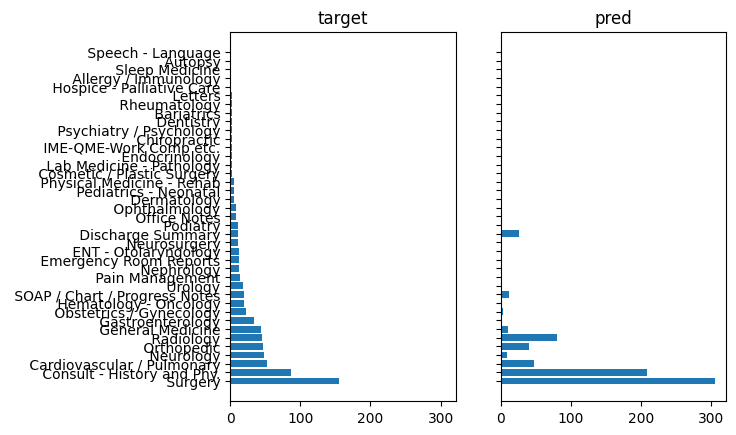

In [77]:
counts_tar = results['target'].value_counts()
counts_pred = results['pred'].value_counts()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)
ax1.barh(counts_tar.index, counts_tar.values)
ax1.set_title('target')
ax2.barh(counts_pred.index, counts_pred.values)
ax2.set_title('pred')

plt.show()

In [79]:
# confusion_matrix = pd.crosstab(results['target'], results['pred'],)
# i = confusion_matrix.index.union(confusion_matrix.columns)
# confusion_matrix = confusion_matrix.reindex(index=i, columns=i, fill_value=0)
# sn.heatmap(confusion_matrix.to_numpy(), annot=True)

# Create new dev-model with weights from trained model
This is used for testing the model inference code while developing, without running the entire pipeline.

In [22]:
gpu_instance_type = "ml.g4dn.xlarge"
pytorch_version = "1.9.0"
transformers_version = "4.11.0"
py_version = "py38"

model = HuggingFaceModel(
    name="text-classification-model-123",
    model_data="s3://sagemaker-eu-west-3-101436505502/model/pipelines-kam521dashky-train-model-JzSCBl76CF/output/model.tar.gz",
    sagemaker_session=session,
    source_dir="src",
    entry_point="model.py",
    dependencies=['requirements.txt'],
    role=role_arn,
    transformers_version=transformers_version,
    pytorch_version=pytorch_version,
    py_version=py_version,
)

## Run batch inference (Transformer)
Use latest approved model from model registry

In [41]:
def get_latest_approved_model(model_package_group_name):
    """Retrieves the latest approved model from a given SageMaker model package group."""
    sm_client = boto3.client('sagemaker')
    model_package_arns = sm_client.list_model_packages(
        ModelPackageGroupName=model_package_group_name)["ModelPackageSummaryList"]
    
    approved_model_package_arns = [d for d in model_package_arns if d['ModelApprovalStatus'] == "Approved"]
    
    if len(approved_model_package_arns) != 0:
        model_package_arn = approved_model_package_arns[0]["ModelPackageArn"]
        print(f"The latest approved model-arn is: {model_package_arn}")
        return model_package_arn

    else:
        print(f"There is no approved model in the model-group '{model_package_group_name}'")

In [101]:
def run_batch_inference(input_data_path, output_data_path):
    CONTENT_TYPE_CSV = 'text/csv'
    CONTENT_TYPE_JSON = "application/json"

    model = get_latest_approved_model("training-pipelineModelGroup")
    transformer = model.transformer(
        instance_count=1,
        instance_type='ml.g4dn.xlarge',  # "ml.m5.large"
        output_path=output_data_path,
        accept=CONTENT_TYPE_CSV,
        # strategy = 'SingleRecord',
        # assemble_with = 'Line',
    )

    transformer.transform(
        data=input_data_path,
        content_type=CONTENT_TYPE_CSV,
        # split_type='Line',
    )
    transformer.wait()

In [102]:
input_data_path = f"s3://{default_bucket}/data/val.csv"
output_data_path = f"s3://{default_bucket}/data/out"

run_batch_inference(input_data_path, output_data_path)

The latest approved model-arn is: arn:aws:sagemaker:eu-west-3:101436505502:model-package/training-pipelinemodelgroup/52


# Torch test area

In [27]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm


class MyTokenizer:
    def __init__(self, model_name="distilbert-base-uncased") -> None:
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)

    def tokenize(self, txt_input):
        return self.tokenizer.encode(txt_input, padding="max_length", truncation=True)
    
    
model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=40,
    )


class MyDataset(Dataset):
    def __init__(self, x, y) -> None:
        self.x = torch.tensor(x)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [17]:
tok = MyTokenizer()
texts = list(df.transcription.values)

inputs = tok.tokenizer(texts, padding="max_length", return_tensors='pt', truncation=True)
inputs

{'input_ids': tensor([[  101, 20714,  1024,  ...,     0,     0,     0],
        [  101,  2627,  2966,  ...,  1010, 26572,   102],
        [  101,  2381,  1997,  ...,  4645,  2545,   102],
        ...,
        [  101, 20714,  1024,  ...,  8048,  1999,   102],
        [  101,  2708, 12087,  ..., 27179,  1024,   102],
        [  101,  2381,  1024,  ..., 17758,  2135,   102]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [22]:
dataset = MyDataset(inputs.input_ids, inputs.attention_mask)

dataloader = DataLoader(dataset, shuffle=False, batch_size=10)


/var/folders/b8/mx2blhp93k7blwkppkkv1w_r0000gn/T/ipykernel_9997/2213946952.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x)
/var/folders/b8/mx2blhp93k7blwkppkkv1w_r0000gn/T/ipykernel_9997/2213946952.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)


In [32]:
output = []
for (x, _) in tqdm(list(enumerate(dataloader))[:4]):
    outs = model(x)
    output += torch.argmax(outs.logits.cpu(), dim=1)

print(output)

  0%|          | 0/4 [00:00<?, ?it/s]


AttributeError: 'int' object has no attribute 'size'

# Manage Sagemaker resource

In [ ]:
from sagemaker.experiments.experiment import _Experiment

experiment_name = "q9lp5qy5wd0f-tune-mo-8zsgutfsto"
exp = _Experiment.load(experiment_name=experiment_name, sagemaker_session=sagemaker.Session())
exp._delete_all(action="--force")

# sm = boto3.Session().client('sagemaker')
# sm.delete_experiment(ExperimentName=experiment_name)

def empty_and_delete_model_package(sagemaker_client, mpg_name):
    mpg = sagemaker_client.list_model_packages(
        ModelPackageGroupName=mpg_name,
    )
    
    # Delete model packages if Group not empty
    model_packages = mpg.get('ModelPackageSummaryList')
    if model_packages:
        for mp in model_packages:
            sagemaker_client.delete_model_package(
                ModelPackageName=mp['ModelPackageArn']
            )
            time.sleep(1)

    # Delete model package group
    sagemaker_client.delete_model_package_group(
        ModelPackageGroupName=mpg_name
    )
    
    
    
import time

client = boto3.client(service_name='sagemaker')
mpg_name='training-pipelineModelGroup'

empty_and_delete_model_package(client, mpg_name)


import boto3

search_params={
   # "MaxResults": 10,
   "Resource": "ExperimentTrial",
#    "SearchExpression": { 
#       "Filters": [{ 
#             "Name": "Tags.Project",
#             "Operator": "Equals",
#             "Value": "Project_Binary_Classifier"
#          }]},
#   "SortBy": "Trail.CreationTime",
  "SortOrder": "Ascending"
}

smclient = boto3.client(service_name='sagemaker')
results = smclient.search(**search_params)
results
